In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Load dataset
df = pd.read_excel('data_rumah.xlsx')
df.head(5)

,NO,NAMA RUMAH,HARGA,LB,LT,KT,KM,GRS
0,1,"Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...",3800000000,220,220,3,3,0
1,2,"Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...",4600000000,180,137,4,3,2
2,3,"Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...",3000000000,267,250,4,4,4
3,4,"Rumah Baru Tebet, Tebet, Jakarta Selatan",430000000,40,25,2,2,0
4,5,"Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...",9000000000,400,355,6,5,3


In [ ]:
# Cek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   NO          1010 non-null   int64 
 1   NAMA RUMAH  1010 non-null   object
 2   HARGA       1010 non-null   int64 
 3   LB          1010 non-null   int64 
 4   LT          1010 non-null   int64 
 5   KT          1010 non-null   int64 
 6   KM          1010 non-null   int64 
 7   GRS         1010 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 63.3+ KB


In [ ]:
# Cek deskripsi statistik dari dataset
df.describe()

,NO,HARGA,LB,LT,KT,KM,GRS
count,1010.000000,1.010000e+03,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,505.500000,7.628987e+09,276.539604,237.432673,4.668317,3.607921,1.920792
std,291.706188,7.340946e+09,177.864557,179.957604,1.572776,1.420066,1.510998
min,1.000000,4.300000e+08,40.000000,25.000000,2.000000,1.000000,0.000000
25%,253.250000,3.262500e+09,150.000000,130.000000,4.000000,3.000000,1.000000
50%,505.500000,5.000000e+09,216.500000,165.000000,4.000000,3.000000,2.000000
75%,757.750000,9.000000e+09,350.000000,290.000000,5.000000,4.000000,2.000000
max,1010.000000,6.500000e+10,1126.000000,1400.000000,10.000000,10.000000,10.000000


In [ ]:
# Cek missing values
df.isnull().sum()

NO            0
NAMA RUMAH    0
HARGA         0
LB            0
LT            0
KT            0
KM            0
GRS           0
dtype: int64

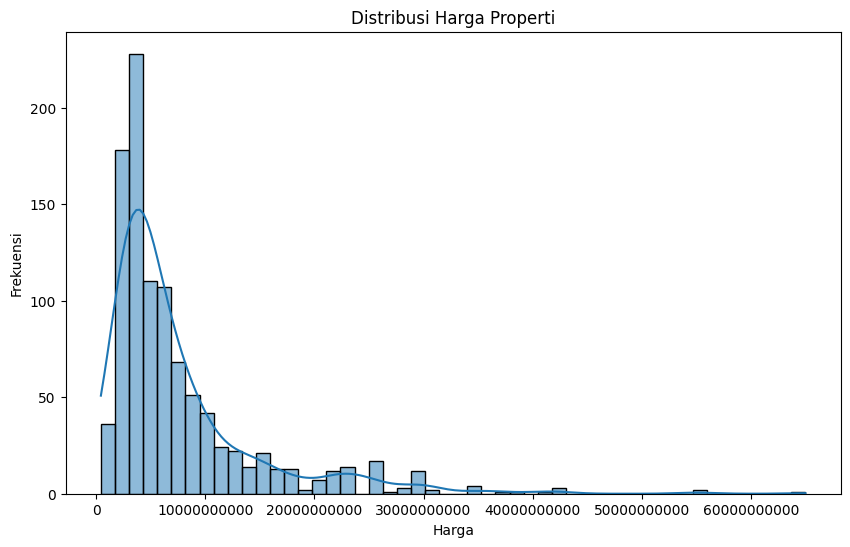

In [ ]:
# Visualisasi distribusi harga
plt.figure(figsize=(10, 6))
sns.histplot(df['HARGA'], kde=True, bins=50)
plt.title('Distribusi Harga Properti')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')
plt.ticklabel_format(style='plain', axis='x') # Matikan notasi ilmiah di sumbu x
plt.show()

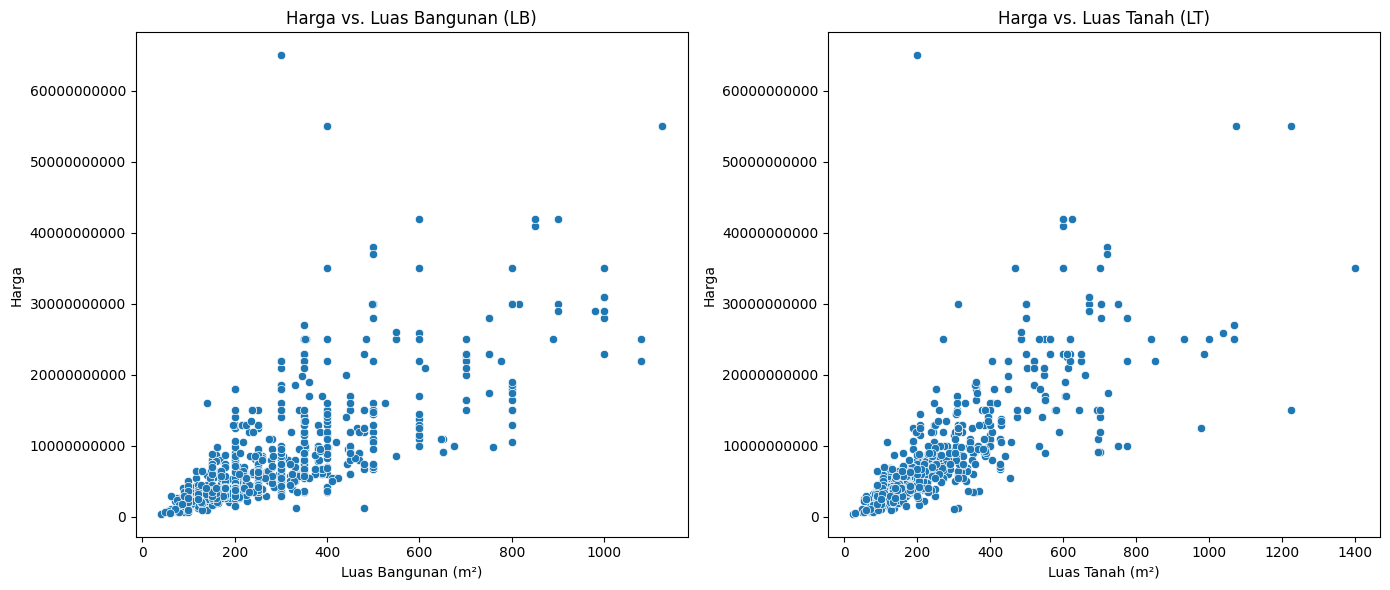

In [ ]:
# Visualisasi hubungan harga dengan LB dan LT
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='LB', y='HARGA', data=df)
plt.title('Harga vs. Luas Bangunan (LB)')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Harga')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1, 2, 2)
sns.scatterplot(x='LT', y='HARGA', data=df)
plt.title('Harga vs. Luas Tanah (LT)')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Harga')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Ekstraksi Fitur dari NAMA RUMAH (NLP Dasar & Regex)
# Kita akan mencoba mengekstrak lokasi dan kata kunci deskriptif

def extract_location(name):
    # Pola regex untuk menangkap kota/kecamatan/area dari string
    match = re.search(r',\s*([A-Za-z\s]+?),\s*([A-Za-z\s]+?)(?:,\s*([A-Za-z\s]+))?$', name)
    if match:
        # Prioritaskan bagian yang lebih spesifik
        if match.group(3): return match.group(3).strip() # Contoh: Jakarta Selatan
        elif match.group(2): return match.group(2).strip() # Contoh: Tebet
        elif match.group(1): return match.group(1).strip() # Contoh: Tebet Timur
    return "Unknown"

# Terapkan ekstraksi lokasi
df['Lokasi_Detail'] = df['NAMA RUMAH'].apply(lambda x: extract_location(x))

# Periksa nilai unik lokasi yang diekstrak
df.tail(5)

,NO,NAMA RUMAH,HARGA,LB,LT,KT,KM,GRS,Lokasi_Detail,HARGA_JUTA,LOG_HARGA,Rational
1005,1006,Rumah Strategis Akses Jalan 2mobil Di Menteng ...,9000000000,450,550,10,10,3,Unknown,9000.0,9.105091,36363.636364
1006,1007,Tebet Rumah Siap Huni Jln 2 Mbl Nyaman,4000000000,160,140,4,3,2,Unknown,4000.0,8.294300,178571.428571
1007,1008,"Di Kebun Baru Rumah Terawat, Area Strategis",4000000000,139,230,4,4,1,Unknown,4000.0,8.294300,125117.297466
1008,1009,Dijual Cepat Rumah Komp Depkeu Dr Soepomo Tebe...,19000000000,360,606,7,4,0,Unknown,19000.0,9.852247,87092.042538
1009,1010,Dijual Rumah Kokoh Di Gudang Peluru,10500000000,420,430,7,4,2,Unknown,10500.0,9.259226,58139.534884


In [ ]:
# Gunakan log agar distribusi target lebih normal
df["LOG_HARGA"] = np.log1p(df["HARGA_JUTA"])  # log(1 + harga)
df['Rational'] = df['HARGA'] / (df['LB'] * df['LT'])
df.head(5)

,NO,NAMA RUMAH,HARGA,LB,LT,KT,KM,GRS,Lokasi_Detail,HARGA_JUTA,LOG_HARGA,Rational
0,1,"Rumah Murah Hook Tebet Timur, Tebet, Jakarta S...",3800000000,220,220,3,3,0,Jakarta Selatan,3800.0,8.243019,78512.396694
1,2,"Rumah Modern di Tebet dekat Stasiun, Tebet, Ja...",4600000000,180,137,4,3,2,Jakarta Selatan,4600.0,8.434029,186536.901865
2,3,"Rumah Mewah 2 Lantai Hanya 3 Menit Ke Tebet, T...",3000000000,267,250,4,4,4,Jakarta Selatan,3000.0,8.006701,44943.820225
3,4,"Rumah Baru Tebet, Tebet, Jakarta Selatan",430000000,40,25,2,2,0,Jakarta Selatan,430.0,6.066108,430000.000000
4,5,"Rumah Bagus Tebet komp Gudang Peluru lt 350m, ...",9000000000,400,355,6,5,3,Jakarta Selatan,9000.0,9.105091,63380.281690


In [ ]:
# Spilitng data menjadi fitur dan target
X = df[["LB", "LT", "KT", "KM", "GRS", "Rational"]]
y = df["LOG_HARGA"]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest Regressor
# Hyperparameter tuning untuk Random Forest Regressor
param_rf = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_rf, cv=3, scoring="r2", n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


In [ ]:
# XGBoost Regressor
# Hyperparameter tuning untuk XGBoost Regressor
param_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=42),
                        param_xgb, cv=3, scoring="r2", n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_


In [ ]:
# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Best Random Forest
y_pred_rf = best_rf.predict(X_test)

# Best XGBoost
y_pred_xgb = best_xgb.predict(X_test)
from sklearn.metrics import mean_squared_error

# Fungsi evaluasi
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": name,
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 4)
    }


# Evaluasi semua model lagi
results = [
    evaluate_model("Linear Regression", y_test, y_pred_lr),
    evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf),
    evaluate_model("XGBoost (Tuned)", y_test, y_pred_xgb)
]

results_df = pd.DataFrame(results)
print(results_df)



                   Model   MSE  RMSE  R2 Score
0      Linear Regression  0.12  0.34    0.7797
1  Random Forest (Tuned)  0.02  0.14    0.9609
2        XGBoost (Tuned)  0.01  0.09    0.9828


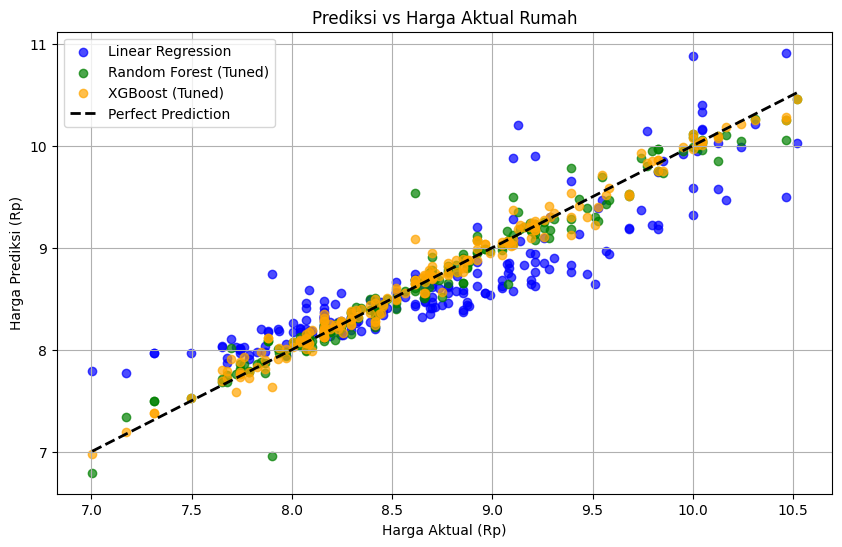

In [ ]:
# Visualisasi perbandingan prediksi vs aktual
plt.figure(figsize=(10,6))

plt.scatter(y_test, y_pred_lr, alpha=0.7, label="Linear Regression", color="blue")
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Random Forest (Tuned)", color="green")
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label="XGBoost (Tuned)", color="orange")

# Garis ideal prediksi sempurna
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=2, label="Perfect Prediction")

plt.xlabel("Harga Aktual (Rp)")
plt.ylabel("Harga Prediksi (Rp)")
plt.title("Prediksi vs Harga Aktual Rumah")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Simpan model log
joblib.dump(best_xgb, "rumah_model.pkl")


['rumah_model.pkl']